In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Download NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alesac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
ts_data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
ts_data.head()

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,...,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
ID,,,,,,,,,,,,,,,,,,,,,
0,Fortnight (feat. Post Malone),Synth Pop,Single,228965,Post Malone,No,0,648525069,1,The Tortured Poets Department: The Anthology,...,spotify:track:6dODwocEuGzHAavXqTbwHv,0.5020,0.504,0.386,1.53e-05,0.0961,-10.976,0.0308,192.004,0.281
1,The Tortured Poets Department,Synth Pop,B-Side,293048,No,No,0,206954130,6,The Tortured Poets Department: The Anthology,...,spotify:track:4PdLaGZubp4lghChqp8erB,0.0483,0.604,0.428,0.0,0.1260,-8.441,0.0255,110.259,0.292
2,My Boy Only Breaks His Favorite Toys,Synth Pop,B-Side,203801,No,No,0,238016975,7,The Tortured Poets Department: The Anthology,...,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.1370,0.596,0.563,0.0,0.3020,-7.362,0.0269,97.073,0.481
3,Down Bad,R&B,B-Side,261228,No,No,0,318375377,2,The Tortured Poets Department: The Anthology,...,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.5600,0.541,0.366,"1,00E-06",0.0946,-10.412,0.0748,159.707,0.168
4,"So Long, London",Synth Pop,B-Side,262974,No,No,0,253712712,4,The Tortured Poets Department: The Anthology,...,spotify:track:7wAkQFShJ27V8362MqevQr,0.7300,0.423,0.533,0.00264,0.0816,-11.388,0.3220,160.218,0.248


In [4]:
#print size of the dataset
rows, columns = ts_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  577
Number of columns:  27


In [5]:
# print name of columns
print(ts_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'duration_ms',
       'feature', 'track_videoclip', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'release_date', 'album_physical_sales', 'track_lyrics',
       'track_theme', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [6]:
# chnage the type of certain columns of the dataset
ts_data['release_date'] = pd.to_datetime(ts_data['release_date'], format='%d/%m/%Y')
ts_data['spotify_streams'] = ts_data['spotify_streams'].str.replace('.', '')
ts_data['spotify_streams'] = pd.to_numeric(ts_data['spotify_streams'], errors='coerce')

# We know that there are duplicates, so we want to merge the rows with duplicates and if two fields are different then save the list with all of the possible values

In [7]:
# print how many instances of a sonng are there in the dataset
print(ts_data['track_name'].value_counts())

track_name
Sweet Nothing                           3
Karma                                   3
Labyrinth                               3
Bejeweled                               3
Maroon                                  3
                                       ..
Stay Beautiful                          1
Should've Said No                       1
Mary's Song (Oh My My My)               1
A Perfectly Good Heart                  1
Teardrops on My Guitar - Pop Version    1
Name: count, Length: 361, dtype: int64


In [8]:
text_columns = [
    'track_musical_genre', 'track_type', 'feature', 'track_videoclip', 
    'album', 'track_number', 'album_musical_genre', 'album_type', 
    'track_lyrics', 'track_theme', 'uri', 'release_date'
]
numerical_columns = [
    'duration_ms', 'videoclip_views', 'spotify_streams', 'spotify_global_peak', 
    'album_physical_sales', 'acousticness', 'danceability', 'energy', 
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

def merge_values(column_values):
    unique_values = column_values.dropna().unique()
    if len(unique_values) == 1:
        return unique_values[0]  # Return single value if all values are the same
    else:
        return list(unique_values)  # Return list of unique values if there are multiple

# Group by 'track_name' and aggregate
merged_data = ts_data.groupby('track_name').agg(
    {col: merge_values for col in text_columns + numerical_columns}
).reset_index()

# Display the merged data
merged_data.head()


,track_name,track_musical_genre,track_type,feature,track_videoclip,album,track_number,album_musical_genre,album_type,track_lyrics,...,album_physical_sales,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,"""Slut!"" (Taylor's Version) (From The Vault)",Synth Pop,Single,No,No,"[1989 (Taylor's Version) [Deluxe], 1989 (Taylo...",17,Pop,"[Compilation/Deluxe, Re-recording]","Flamingo pink, Sunrise Boulevard Clink, clink,...",...,"[0, 4.999.000]","[0.309, 0.345]","[0.591, 0.629]","[0.412, 0.413]","[0.000199, 7.62e-05]","[0.0608, 0.0603]","[-13.27, -13.178]","[0.0863, 0.055]","[155.875, 77.983]","[0.328, 0.306]"
1,...Ready For It?,Electropop,Single,No,Yes,reputation,1,Electropop,Original Studio,Knew he was a killer first time that I saw him...,...,2.478.000,0.0527,0.613,0.764,0.0,0.197,-6.509,0.136,160.015,0.417
2,22,"[Pop Rock, Pop Rock ]",Single,No,"[No, Yes]",[reputation Stadium Tour Surprise Song Playlis...,"[8, 6]","[Electropop, Pop]","[Compilation, Compilation/Deluxe, Original Stu...",It feels like a perfect night To dress up like...,...,"[0, 650.000, 4.551.000]","[0.00254, 0.00215]","[0.66, 0.658]","[0.733, 0.729]","[0.00146, 0.0013]","[0.0473, 0.0752]","[-6.564, -6.561]","[0.0379, 0.0378]","[104.009, 104.007]","[0.68, 0.668]"
3,22 (Taylor's Version),Pop Rock,B-Side,No,No,Red (Taylor's Version),6,Pop,Re-recording,It feels like a perfect night To dress up like...,...,974.000,0.000443,0.642,0.695,1.02e-05,0.0753,-5.62,0.0281,103.984,0.642
4,A Perfectly Good Heart,Country Pop,B-Side,No,No,Taylor Swift,14,Country,Original Studio,Why would you wanna break A perfectly good hea...,...,5.871.000,0.00349,0.483,0.751,0.0,0.128,-5.726,0.0365,156.092,0.268


### Remove the '(Taylor's Version)'

In [9]:
# def simplify_title(title):
#     """Simplify title by removing any version indicators like '(Taylor's Version)'."""
#     return re.sub(r"\(.*?\)", "", title).strip()

def simplify_title(title):
    """Simplify title by removing only '(Taylor's Version)'."""
    return re.sub(r"\(Taylor's Version\)", "", title).strip()

def merge_values(column_values):
    # Flatten lists in column_values
    flattened_values = []
    for value in column_values.dropna():
        if isinstance(value, list):
            flattened_values.extend(value)  # Unpack list values into flattened_values
        else:
            flattened_values.append(value)
    
    # Convert to a unique set and back to list for further processing
    unique_values = pd.Series(flattened_values).unique()
    
    if len(unique_values) == 1:
        return unique_values[0]  # Return single unique value if all values are the same
    else:
        return list(unique_values)  # Return list of unique values if there are multiple

# Group by 'simplified_title' and aggregate with the modified function
merged_data['simplified_title'] = merged_data['track_name'].apply(simplify_title)
final_merged_data = merged_data.groupby('simplified_title').agg(
    {col: merge_values for col in text_columns + numerical_columns}
).reset_index()

# Rename 'simplified_title' back to 'track_name' for clarity
final_merged_data.rename(columns={'simplified_title': 'track_name'}, inplace=True)

# Display the final merged data
final_merged_data.head()



,track_name,track_musical_genre,track_type,feature,track_videoclip,album,track_number,album_musical_genre,album_type,track_lyrics,...,album_physical_sales,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,"""Slut!"" (From The Vault)",Synth Pop,Single,No,No,"[1989 (Taylor's Version) [Deluxe], 1989 (Taylo...",17,Pop,"[Compilation/Deluxe, Re-recording]","Flamingo pink, Sunrise Boulevard Clink, clink,...",...,"[0, 4.999.000]","[0.309, 0.345]","[0.591, 0.629]","[0.412, 0.413]","[0.000199, 7.62e-05]","[0.0608, 0.0603]","[-13.27, -13.178]","[0.0863, 0.055]","[155.875, 77.983]","[0.328, 0.306]"
1,...Ready For It?,Electropop,Single,No,Yes,reputation,1,Electropop,Original Studio,Knew he was a killer first time that I saw him...,...,2.478.000,0.0527,0.613,0.764,0.0,0.197,-6.509,0.136,160.015,0.417
2,22,"[Pop Rock, Pop Rock ]","[Single, B-Side]",No,"[No, Yes]",[reputation Stadium Tour Surprise Song Playlis...,"[8, 6]","[Electropop, Pop]","[Compilation, Compilation/Deluxe, Original Stu...",It feels like a perfect night To dress up like...,...,"[0, 650.000, 4.551.000, 974.000]","[0.00254, 0.00215, 0.000443]","[0.66, 0.658, 0.642]","[0.733, 0.729, 0.695]","[0.00146, 0.0013, 1.02e-05]","[0.0473, 0.0752, 0.0753]","[-6.564, -6.561, -5.62]","[0.0379, 0.0378, 0.0281]","[104.009, 104.007, 103.984]","[0.68, 0.668, 0.642]"
3,A Perfectly Good Heart,Country Pop,B-Side,No,No,Taylor Swift,14,Country,Original Studio,Why would you wanna break A perfectly good hea...,...,5.871.000,0.00349,0.483,0.751,0.0,0.128,-5.726,0.0365,156.092,0.268
4,A Place in this World,Country Pop,B-Side,No,No,[reputation Stadium Tour Surprise Song Playlis...,"[29, 4]","[Electropop, Country]","[Compilation, Original Studio]","I don't know what I want, so don't ask me 'Cau...",...,"[0, 5.871.000]","[0.0577, 0.051]","[0.573, 0.576]","[0.767, 0.777]",0.0,"[0.327, 0.32]","[-2.929, -2.881]","[0.0323, 0.0324]","[114.984, 115.028]","[0.438, 0.428]"


In [10]:
print(final_merged_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'feature',
       'track_videoclip', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'track_lyrics', 'track_theme', 'uri', 'release_date',
       'duration_ms', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album_physical_sales', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence'],
      dtype='object')


In [11]:
#print size of the dataset
rows, columns = final_merged_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  296
Number of columns:  27


# Build the network

### Clean the lyrics

In [12]:
# Define text cleaning function
def clean_text(text):
    # If the input is a list, join elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [13]:
# Apply text cleaning
final_merged_data['cleaned_lyrics'] = final_merged_data['track_lyrics'].apply(clean_text)

# Display the cleaned data
final_merged_data[['track_name', 'cleaned_lyrics']].head()

,track_name,cleaned_lyrics
0,"""Slut!"" (From The Vault)",flamingo pink sunrise boulevard clink clink yo...
1,...Ready For It?,knew killer first time saw wondered many girls...
2,22,feels like perfect night dress like hipsters m...
3,A Perfectly Good Heart,would wanna break perfectly good heart would w...
4,A Place in this World,dont know want dont ask cause im still trying ...


In [14]:
# Calculate TF-IDF scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(final_merged_data['cleaned_lyrics'])

In [15]:
# Step 1: Get feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 2: Convert the TF-IDF matrix to a DataFrame for easier inspection
# Use song titles (or any unique identifier) as row indices
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=final_merged_data['track_name'])

# Step 3: Display the first few rows of the TF-IDF DataFrame
tfidf_df.head()


,158,16th,17,1830s,1944,1950s,1958,2003,230,25,...,youi,youll,young,younger,youplease,youre,youth,youve,zayn,zlister
track_name,,,,,,,,,,,,,,,,,,,,,
"""Slut!"" (From The Vault)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.065811,0.048761,0.000000,0.0,0.088407,0.0,0.0,0.0,0.0
...Ready For It?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.064604,0.000000,0.046945,0.0,0.000000,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
A Perfectly Good Heart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
A Place in this World,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [16]:
# Step 3: Compute similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert similarity matrix to a DataFrame for easier manipulation
similarity_df = pd.DataFrame(similarity_matrix, index=final_merged_data['track_name'], columns=final_merged_data['track_name'])

# Display a sample of the similarity matrix
similarity_df.head(10)

track_name,"""Slut!"" (From The Vault)",...Ready For It?,22,A Perfectly Good Heart,A Place in this World,Afterglow,All Too Well,All Too Well (10 Minute Version) (From The Vault),All You Had To Do Was Stay,Anti-Hero,...,the 1 - the long pond studio sessions,the lakes - bonus track,the lakes - the long pond studio sessions,the last great american dynasty,the last great american dynasty - the long pond studio sessions,this is me trying,this is me trying - the long pond studio sessions,tis the damn season,tolerate it,willow
track_name,,,,,,,,,,,,,,,,,,,,,
"""Slut!"" (From The Vault)",1.000000,0.049562,0.024594,0.024474,0.086706,0.098282,0.127429,0.140385,0.024170,0.034282,...,0.069156,0.053542,0.053542,0.024262,0.024262,0.036030,0.036030,0.064742,0.071812,0.033608
...Ready For It?,0.049562,1.000000,0.042905,0.015839,0.081135,0.052824,0.060001,0.051451,0.037445,0.028119,...,0.076517,0.017757,0.017757,0.022937,0.022937,0.042190,0.042190,0.017940,0.029831,0.047664
22,0.024594,0.042905,1.000000,0.010586,0.111462,0.102616,0.080417,0.061844,0.072824,0.020375,...,0.069818,0.045599,0.045599,0.029121,0.029121,0.049461,0.049461,0.016494,0.029127,0.032541
A Perfectly Good Heart,0.024474,0.015839,0.010586,1.000000,0.017161,0.255450,0.031436,0.030385,0.018454,0.008510,...,0.039484,0.016390,0.016390,0.015175,0.015175,0.023385,0.023385,0.036630,0.048364,0.027036
A Place in this World,0.086706,0.081135,0.111462,0.017161,1.000000,0.110773,0.147978,0.106966,0.042404,0.073415,...,0.076426,0.067926,0.067926,0.061359,0.061359,0.231020,0.231020,0.100800,0.076929,0.139187
Afterglow,0.098282,0.052824,0.102616,0.255450,0.110773,1.000000,0.056233,0.069616,0.216837,0.032669,...,0.080621,0.065867,0.065867,0.020045,0.020045,0.060301,0.060301,0.035764,0.101909,0.049565
All Too Well,0.127429,0.060001,0.080417,0.031436,0.147978,0.056233,1.000000,0.753133,0.048979,0.034732,...,0.066134,0.033695,0.033695,0.033019,0.033019,0.086407,0.086407,0.092310,0.057799,0.057691
All Too Well (10 Minute Version) (From The Vault),0.140385,0.051451,0.061844,0.030385,0.106966,0.069616,0.753133,1.000000,0.072225,0.037816,...,0.087300,0.040623,0.040623,0.039134,0.039134,0.055075,0.055075,0.076017,0.064112,0.065431
All You Had To Do Was Stay,0.024170,0.037445,0.072824,0.018454,0.042404,0.216837,0.048979,0.072225,1.000000,0.010043,...,0.024197,0.017947,0.017947,0.021821,0.021821,0.057606,0.057606,0.042564,0.013494,0.067516


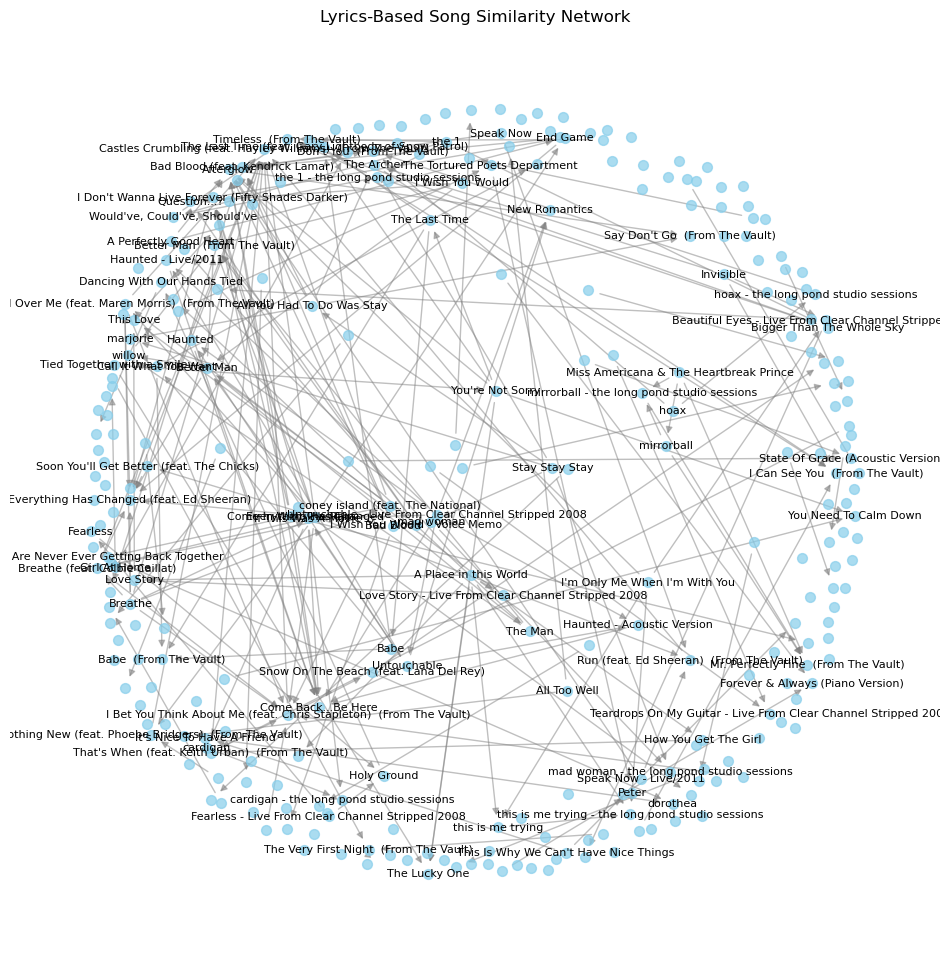

In [17]:
# Define a similarity threshold to determine if a connection should be made
similarity_threshold = 0.2  # Adjust based on your preference

# Initialize a directed graph
G = nx.DiGraph()

def get_earliest_date(dates):
    # Check if dates is already in list format; if not, make it a list
    if not isinstance(dates, list):
        dates = [dates]
    # Convert to datetime and find the earliest date
    return min(pd.to_datetime(dates, dayfirst=True))

# Step 1: Add nodes (songs) to the graph
for song in final_merged_data['track_name']:
    G.add_node(song, release_date=final_merged_data.loc[final_merged_data['track_name'] == song, 'release_date'].values[0])

# Step 2: Add edges based on similarity and release date
for i, song1 in enumerate(final_merged_data['track_name']):
    for j, song2 in enumerate(final_merged_data['track_name']):
        if i != j:
            similarity_score = similarity_df.loc[song1, song2]
            if similarity_score > similarity_threshold:
                # Get release dates for both songs
                date1_raw = final_merged_data.loc[final_merged_data['track_name'] == song1, 'release_date'].values[0]
                date2_raw = final_merged_data.loc[final_merged_data['track_name'] == song2, 'release_date'].values[0]

                date1 = get_earliest_date(date1_raw)
                date2 = get_earliest_date(date2_raw)

                # Add a directed edge from the older song to the newer one
                if date1 < date2:
                    G.add_edge(song1, song2, weight=similarity_score)
                elif date2 < date1:
                    G.add_edge(song2, song1, weight=similarity_score)

# Step 3: Visualize the network
plt.figure(figsize=(12, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), edge_color='gray', alpha=0.5)

# Add labels to some nodes for clarity
labels = {node: node for node in G.nodes() if G.degree[node] > 1}  # Show labels only for nodes with multiple connections
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_family="sans-serif")

plt.title("Lyrics-Based Song Similarity Network")
plt.axis("off")
plt.show()


### Compute network based on number of words that the songs have in common and choosing the one that maximize the modularity

In [21]:
def get_top_n_words(tfidf_row, feature_names, n):
    """Returns the top N words for a song based on TF-IDF scores."""
    sorted_indices = tfidf_row.argsort()[::-1][:n]
    return set(feature_names[i] for i in sorted_indices)

In [22]:
from networkx.algorithms.components import connected_components
from networkx.algorithms.community import greedy_modularity_communities

results = []

for n_top_words in range(2, 10):
    # Initialize a new directed graph for each threshold
    G = nx.DiGraph()
    
    # Add nodes with song attributes
    for song in final_merged_data['track_name']:
        G.add_node(song, release_date=final_merged_data.loc[final_merged_data['track_name'] == song, 'release_date'].values[0])
    
    # Add edges based on the similarity of top words
    for i, song1 in enumerate(final_merged_data['track_name']):
        top_words1 = get_top_n_words(tfidf_matrix[i, :].toarray()[0], feature_names, n_top_words)
        for j, song2 in enumerate(final_merged_data['track_name']):
            if i < j:
                top_words2 = get_top_n_words(tfidf_matrix[j, :].toarray()[0], feature_names, n_top_words)
                
                # Check if there is sufficient overlap in top words
                common_words = top_words1.intersection(top_words2)
                if len(common_words) > 0:  # Link if there's at least one common word
                    date1_raw = final_merged_data.loc[final_merged_data['track_name'] == song1, 'release_date'].values[0]
                    date2_raw = final_merged_data.loc[final_merged_data['track_name'] == song2, 'release_date'].values[0]
                    date1 = get_earliest_date(date1_raw)
                    date2 = get_earliest_date(date2_raw)
                    
                    if date1 < date2:
                        G.add_edge(song1, song2)
                    elif date2 < date1:
                        G.add_edge(song2, song1)
    
    # Calculate the size of the largest connected component (GCC)
    if len(G) > 0:
        GCC = max(connected_components(G.to_undirected()), key=len)
        gcc_size = len(GCC)
        
        # Calculate modularity using community detection
        communities = list(greedy_modularity_communities(G.to_undirected()))
        modularity = nx.algorithms.community.quality.modularity(G.to_undirected(), communities)
    else:
        gcc_size = 0
        modularity = 0

    # Store the results
    results.append((n_top_words, gcc_size, modularity))


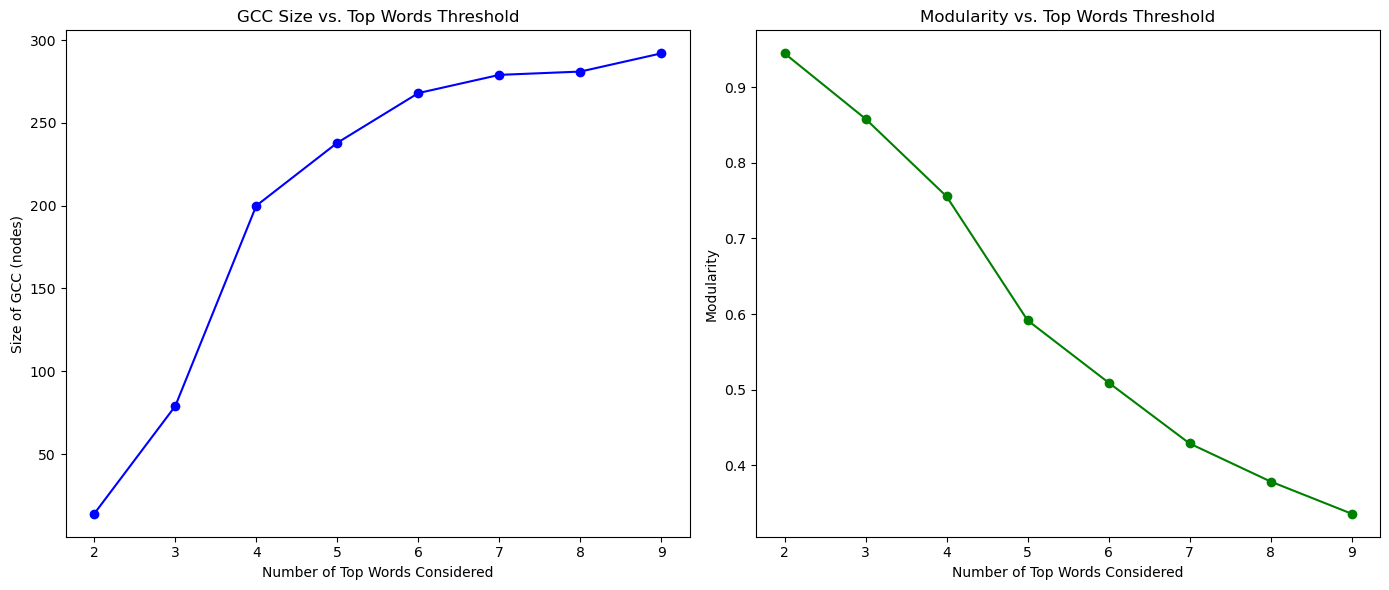

In [23]:
import matplotlib.pyplot as plt

thresholds = [res[0] for res in results]
gcc_sizes = [res[1] for res in results]
modularities = [res[2] for res in results]

plt.figure(figsize=(14, 6))

# Plot GCC size
plt.subplot(1, 2, 1)
plt.plot(thresholds, gcc_sizes, marker='o', color='b')
plt.xlabel("Number of Top Words Considered")
plt.ylabel("Size of GCC (nodes)")
plt.title("GCC Size vs. Top Words Threshold")

# Plot modularity
plt.subplot(1, 2, 2)
plt.plot(thresholds, modularities, marker='o', color='g')
plt.xlabel("Number of Top Words Considered")
plt.ylabel("Modularity")
plt.title("Modularity vs. Top Words Threshold")

plt.tight_layout()
plt.show()


/home/alesac/miniconda/envs/social_graph/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


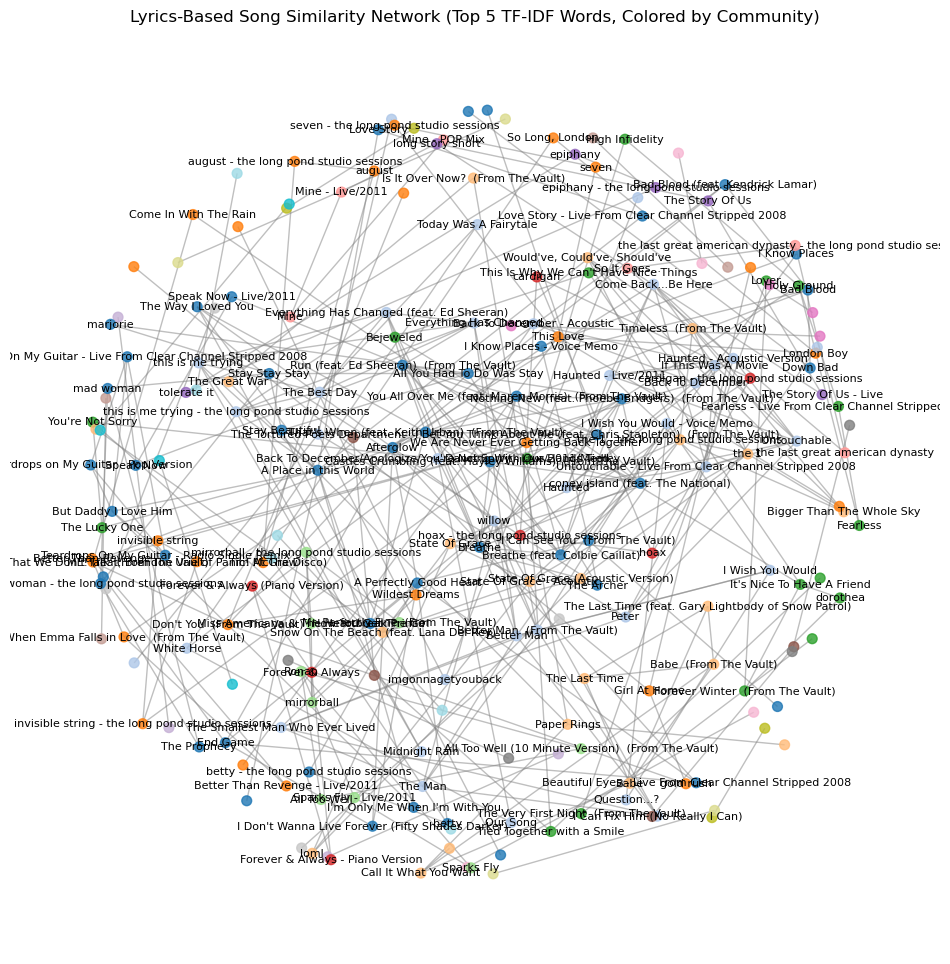

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

# Step 1: Filter the TF-IDF matrix to keep only the top 5 words for each song
top_n = 5  # Number of top TF-IDF words to consider
filtered_tfidf_matrix = tfidf_matrix.copy()

# Zero out values that are not among the top 5 highest scores per song
for i in range(filtered_tfidf_matrix.shape[0]):
    top_indices = filtered_tfidf_matrix[i].toarray().argsort()[0, -top_n:]  # Get indices of top 5 scores
    mask = np.ones(filtered_tfidf_matrix.shape[1], dtype=bool)  # Create a mask
    mask[top_indices] = False  # Invert mask for the top indices
    filtered_tfidf_matrix[i, mask] = 0  # Set non-top indices to 0

# Step 2: Compute the similarity matrix based on the filtered TF-IDF matrix
similarity_matrix_top5 = cosine_similarity(filtered_tfidf_matrix)
similarity_df_top5 = pd.DataFrame(similarity_matrix_top5, index=final_merged_data['track_name'], columns=final_merged_data['track_name'])

# Step 3: Create the network based on a similarity threshold
similarity_threshold = 0.2  # Define an appropriate similarity threshold for linking
G_top5 = nx.Graph()  # Use an undirected graph for community detection

# Add edges based on the similarity threshold
for i, song1 in enumerate(final_merged_data['track_name']):
    for j, song2 in enumerate(final_merged_data['track_name']):
        if i != j:
            similarity_score = similarity_df_top5.loc[song1, song2]
            if similarity_score > similarity_threshold:
                G_top5.add_edge(song1, song2, weight=similarity_score)

# Step 4: Detect communities using the greedy modularity algorithm
communities = list(greedy_modularity_communities(G_top5))
community_map = {}
for community_index, community in enumerate(communities):
    for node in community:
        community_map[node] = community_index

# Step 5: Plot the network with nodes colored by community
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_top5, k=0.5, seed=42)  # Use spring layout for better visualization

# Draw nodes with color based on their community
colors = [community_map[node] for node in G_top5.nodes()]
nx.draw_networkx_nodes(G_top5, pos, node_size=50, node_color=colors, cmap=plt.cm.tab20, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G_top5, pos, edge_color='gray', alpha=0.5)

# Optional: Add labels to a subset of nodes for clarity
labels = {node: node for node in G_top5.nodes() if G_top5.degree[node] > 1}
nx.draw_networkx_labels(G_top5, pos, labels, font_size=8, font_family="sans-serif")

plt.title("Lyrics-Based Song Similarity Network (Top 5 TF-IDF Words, Colored by Community)")
plt.axis("off")
plt.show()


In [25]:
# Step 4: Detect communities using the greedy modularity algorithm
communities = list(greedy_modularity_communities(G_top5))

# Print the number of communities
print(f"Number of communities detected: {len(communities)}")

Number of communities detected: 41


### Degree distribution

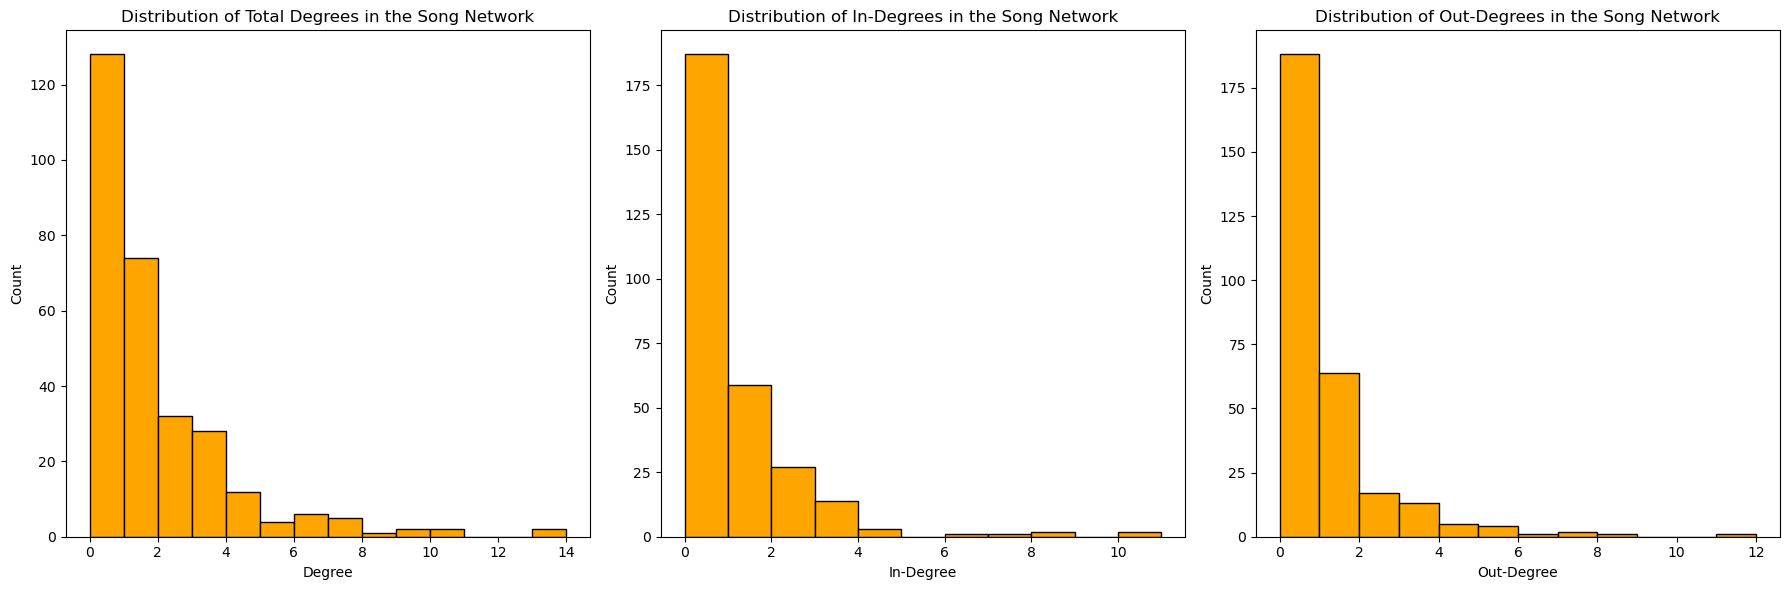

In [19]:
# Calculate degree, in-degree, and out-degree for each node
degrees = [d for n, d in G.degree()]
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total Degree Distribution
axes[0].hist(degrees, bins=range(0, max(degrees) + 1), color='orange', edgecolor='black')
axes[0].set_title('Distribution of Total Degrees in the Song Network')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')

# In-Degree Distribution
axes[1].hist(in_degrees, bins=range(0, max(in_degrees) + 1), color='orange', edgecolor='black')
axes[1].set_title('Distribution of In-Degrees in the Song Network')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Count')

# Out-Degree Distribution
axes[2].hist(out_degrees, bins=range(0, max(out_degrees) + 1), color='orange', edgecolor='black')
axes[2].set_title('Distribution of Out-Degrees in the Song Network')
axes[2].set_xlabel('Out-Degree')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [20]:
from tabulate import tabulate

# Find the top 5 songs with the highest in-degree
top_in_degree = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
in_degree_table = [[song, degree] for song, degree in top_in_degree]

# Find the top 5 songs with the highest out-degree
top_out_degree = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degree_table = [[song, degree] for song, degree in top_out_degree]

# Print tables
print("Top 5 Songs with Highest In-Degree (Most Influenced):")
print(tabulate(in_degree_table, headers=["Song", "In-Degree"], tablefmt="grid"))

print("\nTop 5 Songs with Highest Out-Degree (Most Influential):")
print(tabulate(out_degree_table, headers=["Song", "Out-Degree"], tablefmt="grid"))


Top 5 Songs with Highest In-Degree (Most Influenced):
+--------------------------------------------------------------------+-------------+
| Song                                                               |   In-Degree |
+====================================================================+=============+
| Afterglow                                                          |          11 |
+--------------------------------------------------------------------+-------------+
| Castles Crumbling (feat. Hayley Williams)  (From The Vault)        |          10 |
+--------------------------------------------------------------------+-------------+
| Everything Has Changed (feat. Ed Sheeran)                          |           8 |
+--------------------------------------------------------------------+-------------+
| I Bet You Think About Me (feat. Chris Stapleton)  (From The Vault) |           8 |
+--------------------------------------------------------------------+-------------+
| Come Back